## Ajuste por maximización de Posterior

In [54]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import corner

In [44]:
data = np.load('fit_exercise.npy')                                 #Cargamos el archivo de datos
n = len(data[0])                                                           
va = np.var(data[1])                                               #Varianza en yi
c = 5                                                              #Numero de caminantes
p = 2                                                              #Número de parámetros

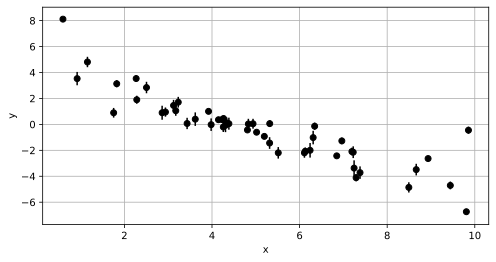

In [5]:
plt.rcParams['figure.figsize'] = (8,4)
plt.errorbar(data[0], data[1], yerr=data[2], xerr = 0, fmt='o', color="black")
#plt.plot(data[0], -0.989*data[0]+4.633)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## Los datos aparentan ajustarse con una función lineal $ax + b$. Se usará el likelihood gaussiano, encontrando el valor de los parámetros que lo maximiza.
## Lo que buscamos es el posterior:
## $P(y,\theta) \propto P(y|\theta)P(\theta)$ donde $P(y|\theta)$ es el likelihood y $P(\theta)$ es el prior, que para este caso será plano y se calculará:
## $P(\theta) = \frac{1}{b-a}$
## y el likelihood:
## $\mathbf{L} \; \propto \; \prod_{i}^{n}\frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(y_i-\lambda(x_i,\theta))^2}{2\sigma^2}}$
## $\ln{(\mathbf{L})} \; \propto \; -\frac{-n}{2}\ln{(2\pi \sigma^2)}-\frac{1}{2\sigma^2}\sum_i^n(y_i-\lambda(x_i,\theta))^2$
### Donde $\lambda(x_i,\theta)$ es el modelo y $\sigma^2$ la varianza de los $y_i$
## Entonces calcularemos:
## $\ln{P(y,\theta)} \propto \ln{P(y|\theta)} + \ln{P(\theta)}$

In [128]:
def prior():
    prio = np.log(1/(max(data[1])-min(data[1])))                      #Aquí se define el prior
    return prio                                                       #Para este caso es plano

In [129]:
def posterior(w):
    llt = 0
    ll = -(n/2)*np.log(2*np.pi*va)
    for i in range (n):
        fx = data[0,i]*w[0] + w[1]                                     #Aquí va el modelo
        llt+= -(data[1,i]-fx)**2
    ll += (1/(2*va))*llt + prior()
    return ll

In [140]:
def metropolis(mm,camt):
    cami = np.zeros((mm,p))
    cami[0],k = camt[0],0                  
    tt = posterior(cami[0])
    for j in range (mm-1):
        for i in range(p):
            camt[j+1,i] = np.random.normal(loc=cami[j,i], scale=0.3)    #Numero aleatorio por cada parametro                          
        ttn = posterior(camt[j+1])
        if ttn>tt:
            cami[j+1] = camt[j+1]                  #Este arreglo solo guarda intentos exitosos
            tt,k = ttn,k+1
            k+=1
        else:
            if (ttn-tt) > np.log(np.random.uniform(low=0.0, high=1.0)):            #"Volado"
                cami[j+1] = camt[j+1]                           
                tt,k = ttn,k+1
            else:
                cami[j+1] = cami[j]
    return cami,camt,k

In [131]:
def caminante(nn):
    cam,camin = np.zeros((c,m,p)),np.zeros((c,m,p))       #((numero de caminantes,m,número de parámetros))
    kk = np.zeros(c)                                      #Contador de casos exitosos
    cam[0] = np.array([0,0])                              #Aquí van los valores iniciales de la caminata
    cam[1] = np.array([0,-1])                             #Lo pongo así para que sea más visual y fácil cambiar
    cam[2] = np.array([0,2])
    cam[3] = np.array([-1,0])
    cam[4] = np.array([-1,-1])
    for i in range(c):
        camin[i],cam[i],kk[i] = metropolis(nn,cam[i])     #Llamamos a metrópolis una vez por caminante
    return camin,cam,kk

In [227]:
m = 50000                                                 #número de intentos de pasos del caminante
cam,camtt,kj = caminante(m)

### La relación de aceptación para cada caminante fue:

In [228]:
glob = np.zeros((0,p))
for i in range(c):
    glob = np.vstack((glob,cam[i]))
print(kj/(m))                           #Ratio de aceptación para cada caminante

[0.3771  0.37574 0.37496 0.37602 0.37508]


### Los valores medios para cada parámetro con un sigma de error fueron:

In [229]:
for i in range(p):
    print('(',np.quantile(glob, .50,axis=0)[i],') + (',
          np.quantile(glob, .84,axis=0)[i]-np.quantile(glob, .50,axis=0)[i],') - (',
          np.quantile(glob, .50,axis=0)[i]-np.quantile(glob, .16,axis=0)[i],')')

( -0.9807741014513132 ) + ( 0.15442034502164048 ) - ( 0.15259173044740915 )
( 4.5737610191598215 ) + ( 0.8288992645827333 ) - ( 0.85712796116144 )


### Los mismos valores calculados con corner:

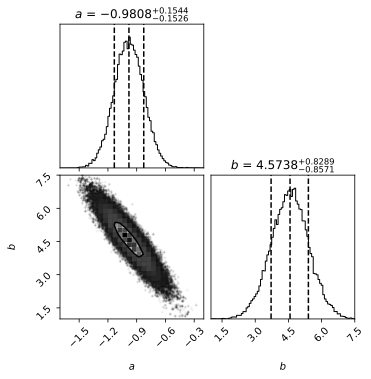

In [230]:
figure = corner.corner(glob, 
                       bins=30,hist_bin_factor=3,
                       range = [[-1.7,-0.2],[1,7.5]],
                       labels=[r"$a$", r"$b$"],       #Compara los parametros con un arreglo de formato = [[a1,b1],[a2,b2]...]
                       title_fmt='.4f',
                       quantiles=[0.16, 0.5, 0.84],         #sigmas
                       levels=(1-np.exp(-0.5),),            #sigma bidimensional
                       show_titles=True, title_kwargs={"fontsize": 12})

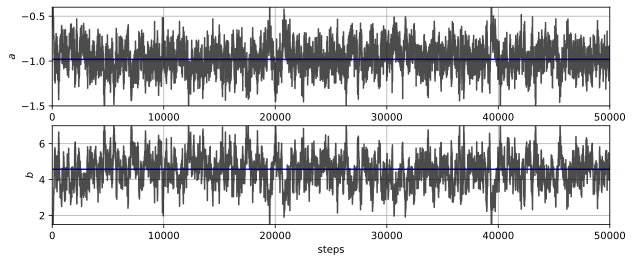

In [231]:
plt.rcParams['figure.figsize'] = (10,4)
stp = np.arange(0,m,1)
plt.subplot(211)
plt.plot(stp, np.hsplit(cam[0],p)[0].reshape((m,1)),color='black',alpha=0.7)
plt.hlines(np.quantile(glob, .50,axis=0)[0], 0, m, colors='blue')
plt.ylim(-1.5, -0.4)
plt.xlim(0, m)
plt.ylabel('$a$')
plt.grid()

plt.subplot(212)
plt.plot(stp, np.hsplit(cam[0],p)[1].reshape((m,1)),color='black',alpha=0.7)
plt.hlines(np.quantile(glob, .50,axis=0)[1], 0, m, colors='blue')
plt.ylim(1.5, 7)
plt.xlim(0, m)
plt.ylabel('$b$')

plt.xlabel('steps')
plt.grid()
plt.show()

## Diagnóstico de Gelman-Rubin
### Método para comprobar convergencia de la cadena
## $\hat{R} = \sqrt{\frac{\hat{\sigma}^2}{s^2}}$ Cuando $R\leq \delta$ para un $\delta>1$, la cadena podría converger.
### Donde: 
# $\hat{\sigma}^2 = \frac{n-1}{n}s^2+\frac{B}{n}$
# $\frac{B}{n} = \frac{1}{m-1}\sum_{i=1}^m (\bar{X}_i-\hat{\mu})^2$
# $s^2 = \frac{1}{m}\sum_{i=1}^m s_i^2$
# $s_i^2 = \frac{1}{n-1}\sum_{t=1}^n(X_{it}-\bar{X}_i)^2$
## $\bar{X_i} = $ media para la cadena $i$ para un parámetro dado
## $n = $ Muestras para cada cadena
## $m = $ Número de cadenas
## $\hat{\mu} = $ Valor promedio para cada parámetro (Promedio de los promedios)


## Los valores calculados de R para cada parámetro fueron:

In [232]:
s,me,R = np.zeros((c,p)),np.zeros((c,p)),np.zeros((p))
for i in range(c):
    s[i],me[i] = np.var(cam[i],axis=0,ddof=1),np.mean(cam[i],axis=0)
st = np.mean(s**2,axis=0)
for j in range(p):
    R[j] = np.sqrt(((((m-1)/m)*st[j])+ np.var(me,axis=0,ddof=1)[j])/st[j])

print(' R = ',R,'\n\n','Y las medias para cada caminante fueron:','\n',me)

 R =  [1.04687291 1.00203696] 

 Y las medias para cada caminante fueron: 
 [[-0.96781198  4.48564504]
 [-0.97952587  4.55978444]
 [-0.98112667  4.57689396]
 [-0.98787871  4.61368243]
 [-0.98380118  4.58205418]]
